# Unet ++ Model
@author: BAIM Mohamed Jalal, 313551810

In [1]:
# Additional library
!pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 37.8 MB/s eta 0:00:00a 0:00:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=297f35ba6e00b2373f4c31b22ca1d4db3b6ef19582a66f49fca767f0aaaa939b
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=1469020ca527e7672f74b4cb467bf9d7c9eca2454deab595c4b1bd23837178d4
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientne

In [2]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from PIL import Image
import torchvision
from torch import nn
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn
import torch.optim as optim

## Dataset 

In [3]:
# Paths
train_img_dir = "/kaggle/input/dataset/dataset/train_imgs"
train_label_dir = "/kaggle/input/dataset/dataset/train_lbs"
test_img_dir = "/kaggle/input/dataset/dataset/test_imgs"

In [4]:
# Dataset class
class CustomDataset(Dataset):

    def __init__(self, img_dir, label_dir=None, transform=None):

        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.images = os.listdir(img_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('L')

        if self.label_dir:
            label_name = img_name.replace('.png', '.npy')
            label_path = os.path.join(self.label_dir, label_name)
            label = np.load(label_path)
            #label_resized = Image.fromarray(label).resize((256, 256), resample=Image.NEAREST)
            label_tensor = torch.from_numpy(np.array(label)).long()
        else:
            label_tensor = None

        if self.transform:
            image = self.transform(image)
            
        return image, label_tensor
        
def create_data_loaders(train_img_dir, train_label_dir, batch_size=32, validation_split=0.2):

    """
    Create DataLoaders for train, validation, and test sets.
    Parameters:
        train_img_dir (str): Directory containing the training images.
        train_label_dir (str): Directory containing the training labels.
        test_img_dir (str): Directory containing the test images.
        batch_size (int): Batch size for the DataLoader.
        validation_split (float): Proportion of the training data to use as validation.
    Returns:
        train_loader, val_loader, test_loader (DataLoader): DataLoaders for the train, validation, and test sets.
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    # Load dataset and split into train and validation indices

    full_dataset = CustomDataset(train_img_dir, train_label_dir, transform=transform)
    train_indices, val_indices = train_test_split(range(len(full_dataset)), test_size=validation_split, random_state=42)

    # Create subsets and corresponding DataLoaders

    train_dataset = torch.utils.data.Subset(full_dataset, train_indices)
    val_dataset = torch.utils.data.Subset(full_dataset, val_indices)

    # Create DataLoaders

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader



train_loader, val_loader = create_data_loaders(train_img_dir=train_img_dir,
                                                            train_label_dir=train_label_dir,
                                                            batch_size=16,
                                                            validation_split=0.2)


print("Number of training batches:", len(train_loader))
print("Number of validation batches:", len(val_loader))
print("Number of training samples:", len(train_loader.dataset))
print("Number of validation samples:", len(val_loader.dataset))

Number of training batches: 45
Number of validation batches: 12
Number of training samples: 713
Number of validation samples: 179


In [5]:
transform2 = transforms.Compose([
        transforms.ToTensor()
    ])


class test_dataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform2
        self.images = os.listdir(img_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)
        return image, img_name  # Return both the image tensor and the filename

# Update the DataLoader instantiation
test_data2 = test_dataset(test_img_dir, transform=transform2)
test_loader2 = DataLoader(test_data2, batch_size=32, shuffle=False)

# Print to verify
print("Number of batches in Test:", len(test_loader2))
for images, filenames in test_loader2:
    print(f'Image batch shape: {images.shape}')
    print(f'Filenames: {filenames[:5]}')  # Print the first few filenames to confirm
    break


Number of batches in Test: 5
Image batch shape: torch.Size([32, 1, 224, 224])
Filenames: ('Case_00007_35.png', 'Case_00007_6.png', 'Case_00007_31.png', 'Case_00009_19.png', 'Case_00009_30.png')


## Model

In [6]:
def compute_iou(preds, labels, num_classes):
    """
    Compute IoU for each class.
    Args:
        preds (torch.Tensor): Predicted labels (batch_size, H, W)
        labels (torch.Tensor): True labels (batch_size, H, W)
        num_classes (int): Number of classes
    Returns:
        iou_list (list): List of IoU for each class
    """
    iou_list = []
    preds = preds.view(-1)
    labels = labels.view(-1)

    for cls in range(num_classes):
        pred_inds = preds == cls
        target_inds = labels == cls
        intersection = (pred_inds & target_inds).sum().float().item()
        union = (pred_inds | target_inds).sum().float().item()

        if union == 0:
            iou = float('nan')  # Avoid division by zero
        else:
            iou = intersection / union
        iou_list.append(iou)
    return iou_list

def compute_dice(preds, labels, num_classes):
    """
    Compute Dice Coefficient for each class.
    Args:
        preds (torch.Tensor): Predicted labels (batch_size, H, W)
        labels (torch.Tensor): True labels (batch_size, H, W)
        num_classes (int): Number of classes
    Returns:
        dice_list (list): List of Dice Coefficient for each class
    """
    dice_list = []
    preds = preds.view(-1)
    labels = labels.view(-1)

    for cls in range(num_classes):
        pred_inds = preds == cls
        target_inds = labels == cls
        intersection = (pred_inds & target_inds).sum().float().item()
        pred_sum = pred_inds.sum().float().item()
        target_sum = target_inds.sum().float().item()

        if pred_sum + target_sum == 0:
            dice = float('nan')  # Avoid division by zero
        else:
            dice = (2 * intersection) / (pred_sum + target_sum)
        dice_list.append(dice)
    return dice_list


In [7]:
# Define the UNet++ model
model = smp.UnetPlusPlus(
    encoder_name="efficientnet-b7",        # Choose an encoder, e.g., resnet34 or efficientnet-b0
    encoder_weights= 'imagenet',     # Use 'imagenet' pre-trained weights for encoder initialization
    in_channels=1,                  # Model input channels (1 for grayscale images)
    classes=5,                      # Model output channels (number of classes in your dataset)
)

for param in model.encoder.parameters():
    param.requires_grad = True


# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth
100%|██████████| 254M/254M [00:00<00:00, 348MB/s] 


In [8]:
# Define the Dice loss
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.softmax(inputs, dim=1)  # Apply softmax for multiclass segmentation
        targets = nn.functional.one_hot(targets, num_classes=inputs.shape[1]).permute(0, 3, 1, 2)
        intersection = (inputs * targets).sum(dim=(2, 3))
        union = inputs.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()

# Define training parameters
criterion = nn.CrossEntropyLoss()
#criterion = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20
num_classes = 5

training loop
Epoch [1/20], Train Loss: 0.4633, Val Loss: 0.1714, Mean IoU: 0.3670, Mean Dice: 0.3824
Epoch [2/20], Train Loss: 0.0735, Val Loss: 0.1042, Mean IoU: 0.3955, Mean Dice: 0.4361
Epoch [3/20], Train Loss: 0.0392, Val Loss: 0.0716, Mean IoU: 0.7187, Mean Dice: 0.7562
Epoch [4/20], Train Loss: 0.0244, Val Loss: 0.0488, Mean IoU: 0.7223, Mean Dice: 0.7582
Epoch [5/20], Train Loss: 0.0176, Val Loss: 0.0377, Mean IoU: 0.7454, Mean Dice: 0.7715
Epoch [6/20], Train Loss: 0.0139, Val Loss: 0.0349, Mean IoU: 0.8002, Mean Dice: 0.8676
Epoch [7/20], Train Loss: 0.0111, Val Loss: 0.0203, Mean IoU: 0.8914, Mean Dice: 0.9379
Epoch [8/20], Train Loss: 0.0097, Val Loss: 0.0140, Mean IoU: 0.9068, Mean Dice: 0.9482
Epoch [9/20], Train Loss: 0.0089, Val Loss: 0.0128, Mean IoU: 0.9100, Mean Dice: 0.9497
Epoch [10/20], Train Loss: 0.0078, Val Loss: 0.0133, Mean IoU: 0.9080, Mean Dice: 0.9488
Epoch [11/20], Train Loss: 0.0072, Val Loss: 0.0113, Mean IoU: 0.9118, Mean Dice: 0.9507
Epoch [12/20], T

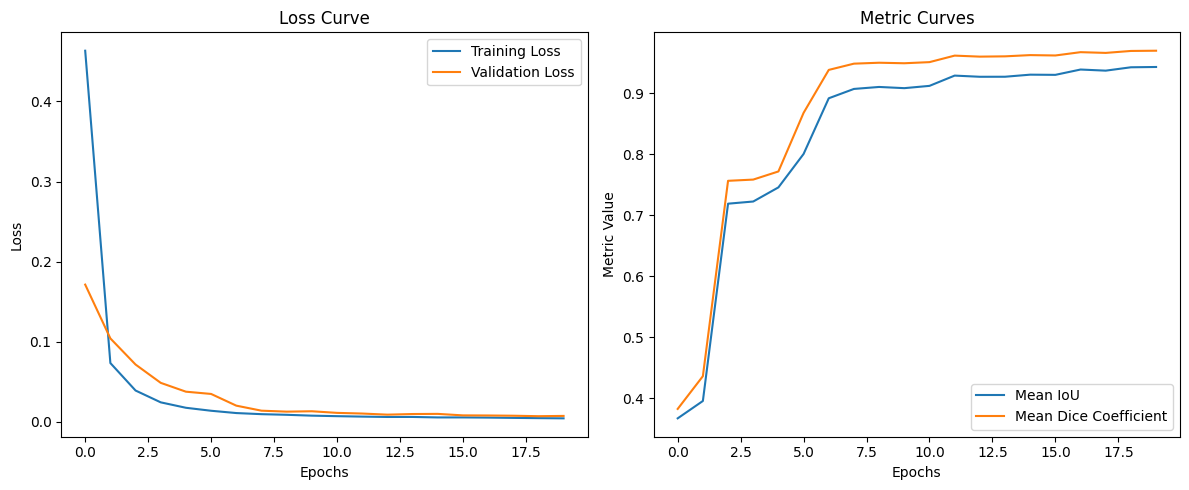

In [9]:
# Initialize lists to store losses and metrics
train_losses = []
val_losses = []
mean_ious = []
mean_dices = []
print('training loop')
for epoch in range(num_epochs):
    # Training loop
    model.train()
    running_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))

    # Validation loop
    model.eval()
    val_loss = 0.0
    # Initialize variables to accumulate metrics
    total_intersections = [0.0] * num_classes
    total_unions = [0.0] * num_classes
    total_preds_sum = [0.0] * num_classes
    total_targets_sum = [0.0] * num_classes

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            # Get predicted labels
            preds = torch.argmax(outputs, dim=1)

            # Compute per-class metrics
            for cls in range(num_classes):
                pred_inds = preds == cls
                target_inds = masks == cls
                intersection = (pred_inds & target_inds).sum().item()
                union = (pred_inds | target_inds).sum().item()
                pred_sum = pred_inds.sum().item()
                target_sum = target_inds.sum().item()

                total_intersections[cls] += intersection
                total_unions[cls] += union
                total_preds_sum[cls] += pred_sum
                total_targets_sum[cls] += target_sum

    val_losses.append(val_loss / len(val_loader))

    # Compute mean IoU and Dice Coefficient
    iou_list = []
    dice_list = []

    for cls in range(num_classes):
        intersection = total_intersections[cls]
        union = total_unions[cls]
        pred_sum = total_preds_sum[cls]
        target_sum = total_targets_sum[cls]

        if union == 0:
            iou = float('nan')  # Avoid division by zero
        else:
            iou = intersection / union

        if pred_sum + target_sum == 0:
            dice = float('nan')  # Avoid division by zero
        else:
            dice = (2 * intersection) / (pred_sum + target_sum)

        iou_list.append(iou)
        dice_list.append(dice)

    # Compute mean values, ignoring NaNs
    mean_iou = np.nanmean(iou_list)
    mean_dice = np.nanmean(dice_list)
    mean_ious.append(mean_iou)
    mean_dices.append(mean_dice)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_losses[-1]:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}, "
          f"Mean IoU: {mean_iou:.4f}, "
          f"Mean Dice: {mean_dice:.4f}")

# Plot loss curves
plt.figure(figsize=(12, 5))

# Loss subplot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Metrics subplot
plt.subplot(1, 2, 2)
plt.plot(mean_ious, label='Mean IoU')
plt.plot(mean_dices, label='Mean Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Metric Value')
plt.title('Metric Curves')
plt.legend()

plt.tight_layout()
plt.show()

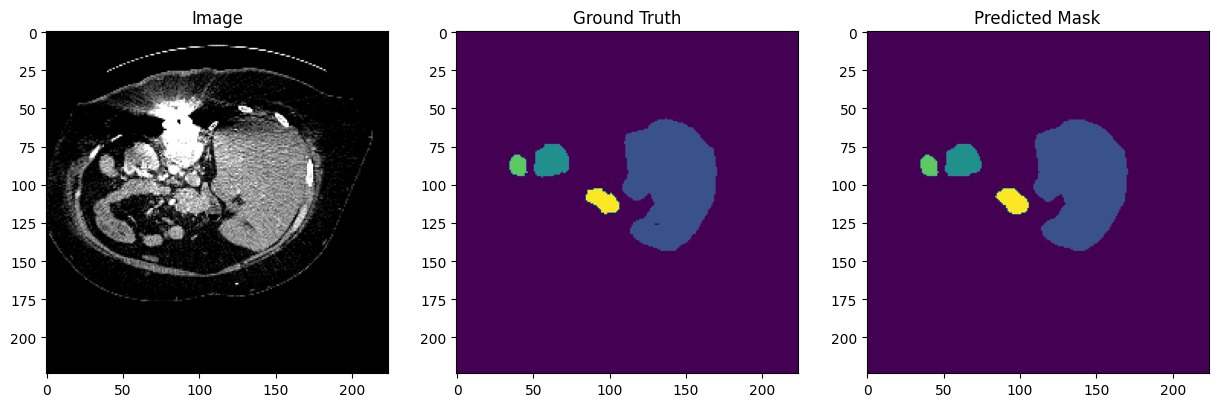

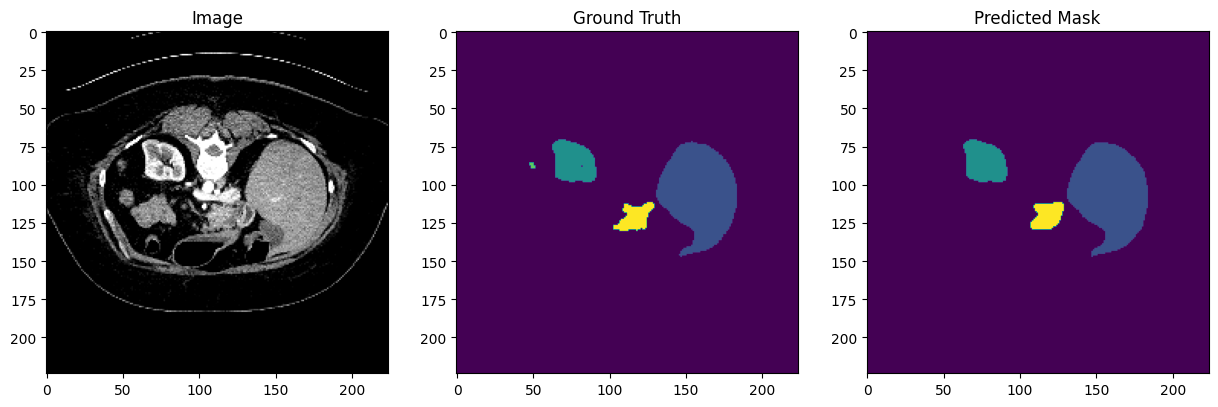

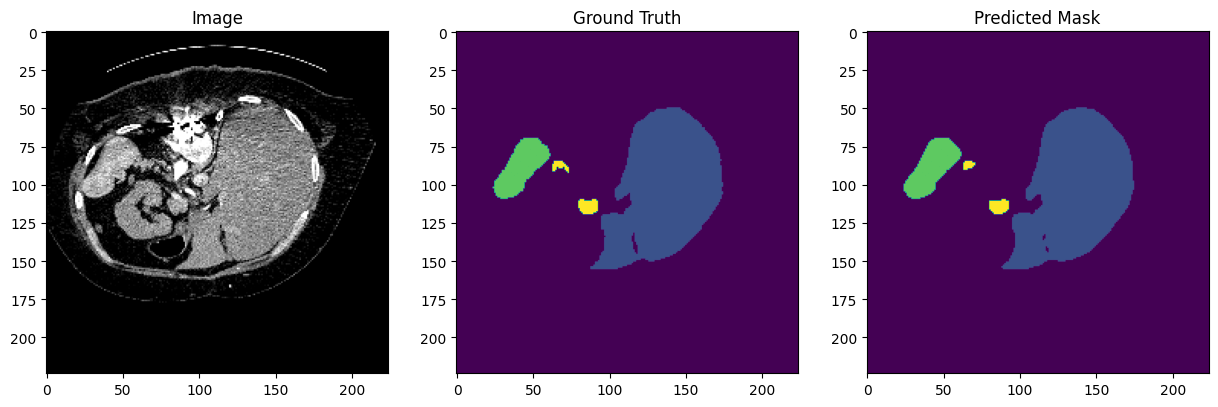

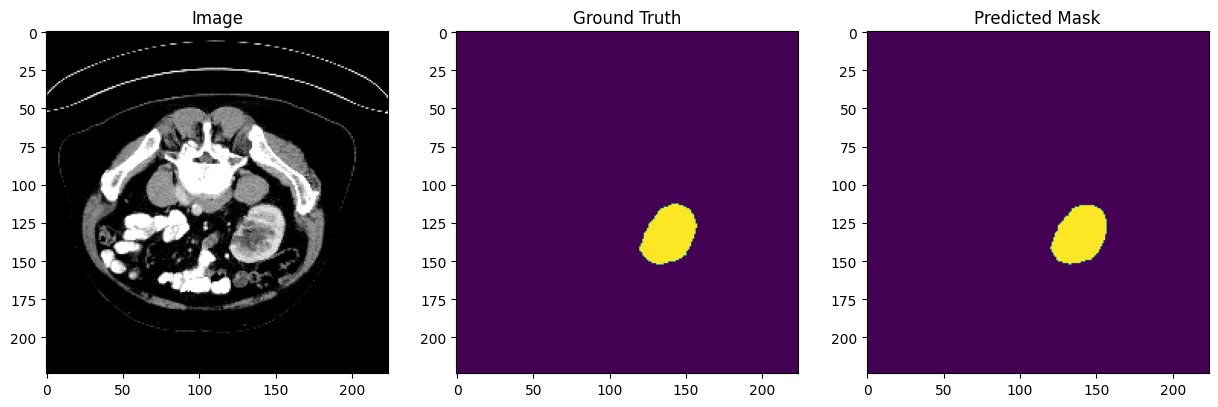

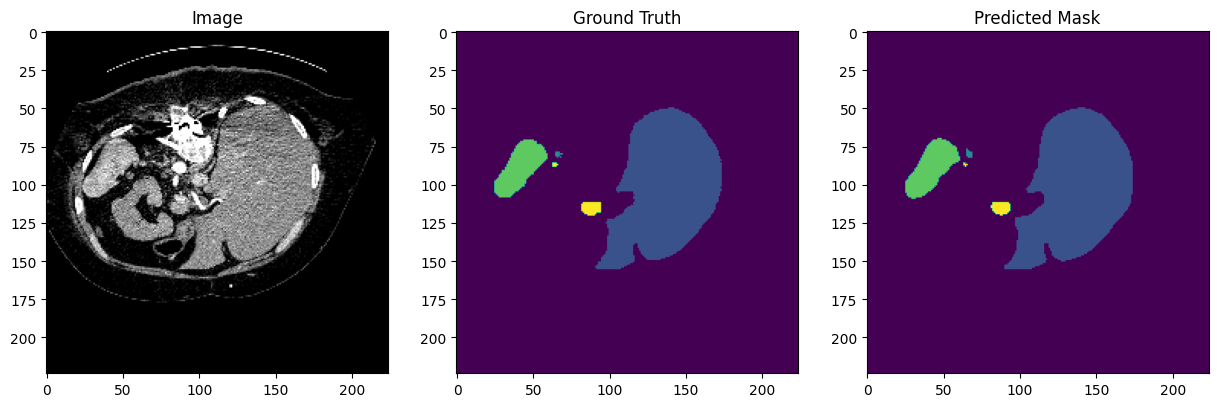

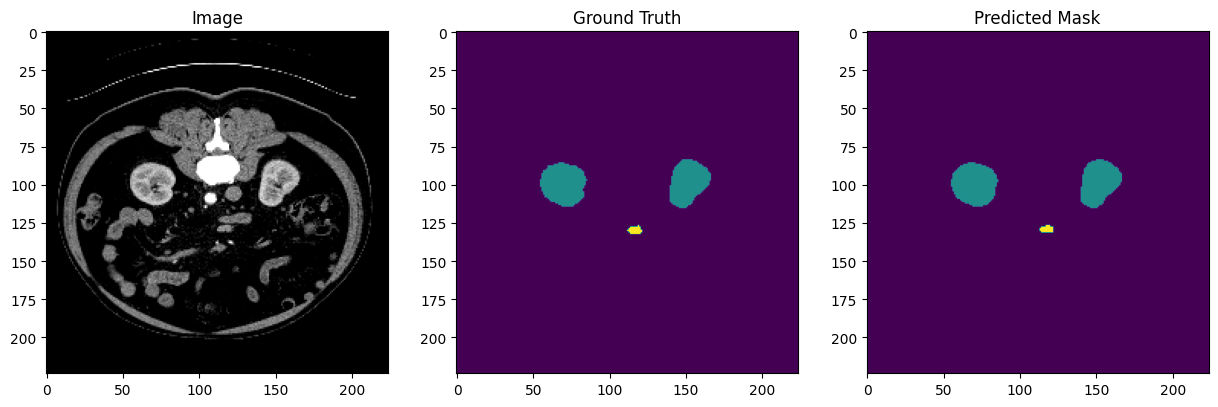

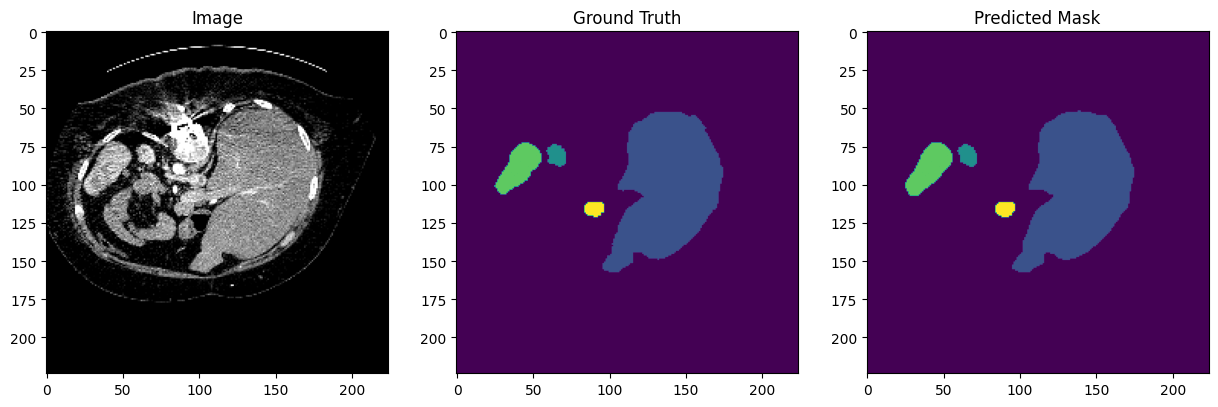

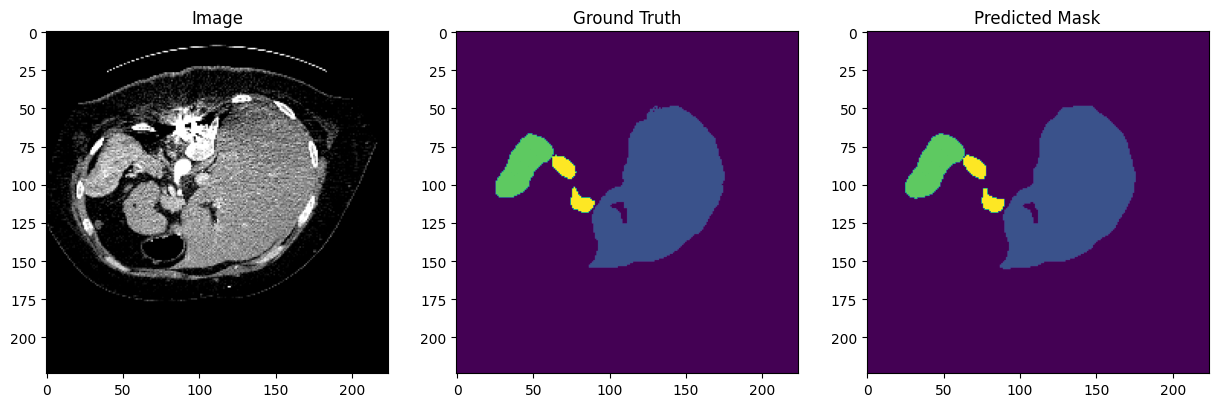

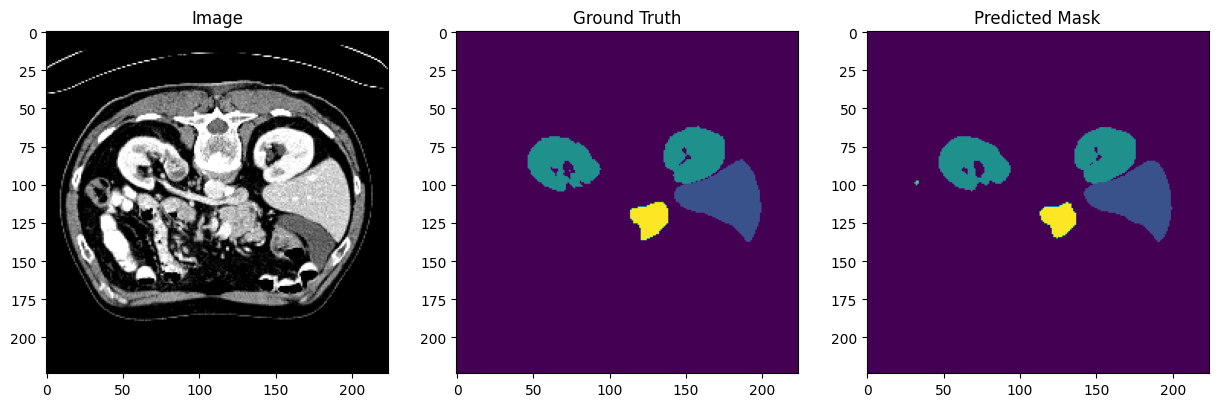

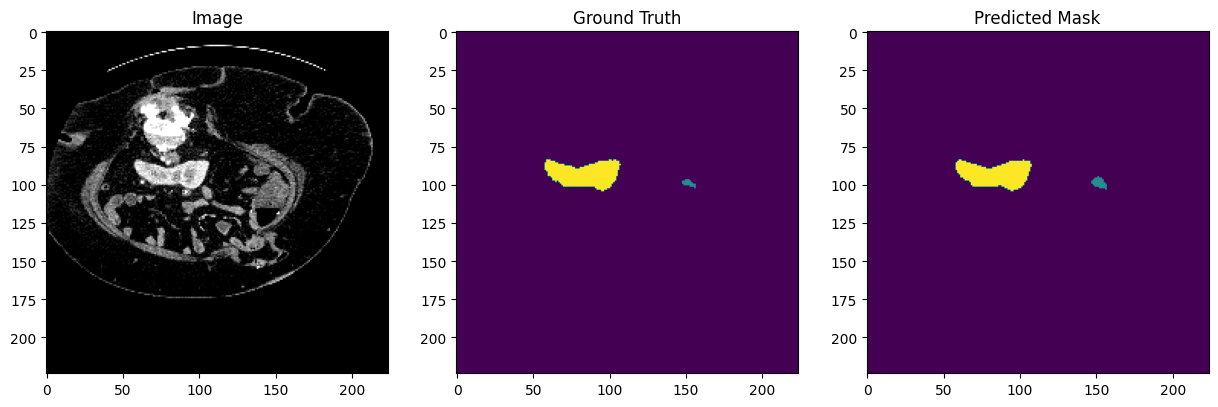

In [10]:
i = 0
# Iterate through validation loader
for val_images, val_labels in val_loader:
    # Select the i-th image and label
    val_img = val_images[i]
    val_label = val_labels[i]

    # Prepare image for model
    val_img = val_img.unsqueeze(0).to(device)

    # Forward pass
    outputs = model(val_img)

    # Get predictions (argmax over classes)
    predictions = outputs.argmax(dim=1).squeeze(0).cpu().numpy()

    # Convert image and ground truth to numpy for visualization
    val_img_np = val_img.squeeze(0).permute(1, 2, 0).cpu().numpy()
    val_label_np = val_label.cpu().numpy()

    # Plot image, ground truth, and predictions
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(val_img_np, cmap ='gray')
    axs[0].set_title('Image')
    axs[1].imshow(val_label_np)
    axs[1].set_title('Ground Truth')
    axs[2].imshow(predictions)
    axs[2].set_title('Predicted Mask')
    plt.show()

    # Stop after visualizing 10 images
    i += 1
    if i == 10:
        break


In [11]:
# Dice score
def dice_score(preds, targets, num_classes=5):
    preds = torch.argmax(preds, dim=1)
    preds_one_hot = nn.functional.one_hot(preds, num_classes=num_classes).permute(0, 3, 1, 2)
    
    # Ensure both preds_one_hot and targets_one_hot have the same type and device
    preds_one_hot = preds_one_hot.type_as(targets)
    
    targets_one_hot = nn.functional.one_hot(targets, num_classes=num_classes).permute(0, 3, 1, 2)
    
    intersection = (preds_one_hot * targets_one_hot).sum(dim=(2, 3))
    union = preds_one_hot.sum(dim=(2, 3)) + targets_one_hot.sum(dim=(2, 3))
    dice = (2. * intersection + 1.0) / (union + 1.0)
    return dice.mean().item()

# Compute dice score on test set
total_dice = 0.0
count = 0
with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        total_dice += dice_score(outputs, masks)
        count += 1

average_dice = total_dice / count
print(f'Average Dice Score on Val Set: {average_dice:.4f}')


Average Dice Score on Val Set: 0.9646


## Evaluation metrics

In [12]:
import torch
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
from tqdm import tqdm

# Define classes for each organ in your dataset
classes = ["Liver", "Kidney", "Spleen", "Pancreas"]

# Store the results
results = {
    "Target": [],
    "F1-score": [],
    "Recall": [],
    "Precision": [],
    "Dice": [],
    "IoU": []
}

print("Loop")
for class_idx, class_name in enumerate(classes):

    y_true = []
    y_pred = []
    # Loop through the images and labels in your validation dataset
    for i, (image, label) in enumerate(tqdm(val_loader, desc=f"Processing {class_name}")):
        with torch.no_grad():  # Disable gradient calculations
            image = image.to(device)  # Move image to the same device as the model
            label = label.to(device)  # Move label to the same device as the model
            # Get the model predictions
            output = model(image)
            predictions = torch.argmax(output, dim=1)
            # Flatten arrays to compare each pixel
            y_true.extend((label == class_idx).cpu().numpy().flatten())
            y_pred.extend((predictions == class_idx).cpu().numpy().flatten())

        # Clear CUDA cache
        torch.cuda.empty_cache()

    # Convert y_true and y_pred to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate metrics for the current class
    precision = precision_score(y_true, y_pred, average='binary', pos_label=1, zero_division=0)
    recall = recall_score(y_true, y_pred, average='binary', pos_label=1, zero_division=0)
    f1 = f1_score(y_true, y_pred, average='binary', pos_label=1, zero_division=0)

    # Dice coefficient is equivalent to F1-score for binary classification
    dice = f1

    # Calculate IoU
    iou = jaccard_score(y_true, y_pred, average='binary', pos_label=1, zero_division=0)

    # Append results to the table
    results["Target"].append(class_name)
    results["F1-score"].append(f1)
    results["Recall"].append(recall)
    results["Precision"].append(precision)
    results["Dice"].append(dice)
    results["IoU"].append(iou)
    
    # Delete lists to free up memory after each class calculation
    del y_true, y_pred

# Convert results to a DataFrame for easy display
import pandas as pd

results_df = pd.DataFrame(results)
print(results_df)

Loop


Processing Pancreas: 100%|██████████| 12/12 [00:03<00:00,  3.86it/s]


     Target  F1-score    Recall  Precision      Dice       IoU
0     Liver  0.998613  0.998331   0.998894  0.998613  0.997229
1    Kidney  0.987198  0.991179   0.983249  0.987198  0.974719
2    Spleen  0.980122  0.980776   0.979469  0.980122  0.961020
3  Pancreas  0.980388  0.991463   0.969557  0.980388  0.961530


# Saving Results 

In [13]:
def rle_encode(mask):
    """Run-length encoding for a 2D mask."""
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# Function to generate the CSV format for submission
def create_submission_csv(test_loader, model, device, output_csv_path='Unetplusefficient_.csv'):
    model.eval()
    submission_data = []
    with torch.no_grad():
        for i, (images, filenames) in enumerate(test_loader):
            images = images.to(device)
            outputs = model(images)
            predictions = outputs.argmax(dim=1).cpu().numpy()  # Get predicted class masks

            # Generate Id and RLE for each image
            for idx, (filename, pred_mask) in enumerate(zip(filenames, predictions)):
                base_name = filename.split('.')[0]  # Extract the base name without extension
                for class_id in range(5):  # Classes: 0 (Background), 1 (Liver), 2 (Kidney), 3 (Spleen), 4 (Pancreas)
                    mask = (pred_mask == class_id).astype(np.uint8)
                    rle = rle_encode(mask) if mask.sum() > 0 else ''  # Encode to RLE if non-empty mask
                    submission_data.append([f"{base_name}_{class_id}", rle])

    # Create DataFrame and save to CSV
    submission_df = pd.DataFrame(submission_data, columns=['Id', 'Predicted'])
    submission_df.to_csv(output_csv_path, index=False)
    print(f"Submission CSV created at {output_csv_path}")

# Example usage
create_submission_csv(test_loader2, model, device)

Submission CSV created at Unetplusefficient_.csv
